## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...Done.


We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [1]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set

## Loading and preparing training data


In [5]:
labels = pd.read_csv("content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, 'content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

X_train = [] # initialize an empty numpy array
y_train = []
image_size = 75      # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
    X_train.append(new_img_array)
    y_train.append(train_data['label'][i])

In [6]:
X_train=np.array(X_train)
y_train=np.array(y_train)

# labeling male as 1 and female as 0
y_train=np.where(y_train=="male",1,0)

In [7]:
print(X_train.shape)
print(y_train.shape)

(9220, 75, 75)
(9220,)


## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [8]:
# reshape for feeding into the model
X_train = X_train.reshape(X_train.shape[0], 75, 75, 1)

print('\nX_train.shape: {}, of {}'.format(X_train.shape, X_train.dtype))


X_train.shape: (9220, 75, 75, 1), of uint8


## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [40]:
# define input shape
INPUT_SHAPE = (75, 75, 1)

# define sequential model
model = tf.keras.models.Sequential()

#define rescaling
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/1, input_shape=(75,75, 1)))

# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 75, 75, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)              

# Validate the model

In [ ]:
EPOCHS = 20
X_train_scaled = X_train / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(X_train_scaled, y_train,
                    batch_size=200,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/20
42/42 [==============================] - 9s 201ms/step - loss: 0.7143 - accuracy: 0.5530 - val_loss: 0.6481 - val_accuracy: 0.7375
Epoch 2/20
42/42 [==============================] - 8s 199ms/step - loss: 0.5429 - accuracy: 0.7319 - val_loss: 0.4780 - val_accuracy: 0.7679
Epoch 3/20
42/42 [==============================] - 8s 202ms/step - loss: 0.4111 - accuracy: 0.8195 - val_loss: 0.3768 - val_accuracy: 0.8330
Epoch 4/20
42/42 [==============================] - 9s 204ms/step - loss: 0.3699 - accuracy: 0.8415 - val_loss: 0.3294 - val_accuracy: 0.8536
Epoch 5/20
42/42 [==============================] - 8s 200ms/step - loss: 0.3216 - accuracy: 0.8658 - val_loss: 0.3139 - val_accuracy: 0.8731
Epoch 6/20
42/42 [==============================] - 8s 201ms/step - loss: 0.2986 - accuracy: 0.8753 - val_loss: 0.3562 - val_accuracy: 0.8395
Epoch 7/20
42/42 [==============================] - 8s 202ms/step - loss: 0.2625 - accuracy: 0.8949 - val_loss: 0.2862 - val_accuracy: 0.8818
Epoch 

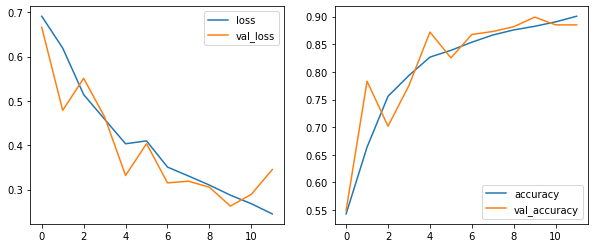

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

In [32]:
labels = pd.read_csv("content/eye_gender_data/Testing_set.csv")   # loading the labels
file_paths = [[fname, 'content/eye_gender_data/test/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_data = pd.merge(images, labels, how = 'inner', on = 'filename')

X_test = [] # initialize an empty numpy array
image_size = 75     # image size taken is 100 here. one can take other size too
for i in range(len(test_data)):
    img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
    X_test.append(new_img_array)

In [33]:
X_test=np.array(X_test)
X_test.shape

(2305, 75, 75)

In [34]:
X_test = X_test / 255.

## Data Pre-processing on test_data


In [35]:
# reshape for feeding into the model
X_test = X_test.reshape(X_test.shape[0], 75, 75, 1)

print('\nX_test.shape: {}, of {}'.format(X_test.shape, X_test.dtype))


X_test.shape: (2305, 75, 75, 1), of float64


### Make Prediction on Test Dataset
Time to make a submission!!!

In [36]:
predictions = model.predict(X_test)
predictions[:5]

array([[0.00315712, 0.99684286],
       [0.14268395, 0.8573161 ],
       [0.02267819, 0.9773218 ],
       [0.07551705, 0.924483  ],
       [0.0044286 , 0.99557143]], dtype=float32)

In [37]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0], dtype=int64)

In [38]:
prediction_labels=np.where(prediction_labels==1,"male","female")

## **How to save prediciton results locally via jupyter notebook?**
If you are working on Jupyter notebook, execute below block of codes. A file named 'submission.csv' will be created in your current working directory.

In [39]:
res = pd.DataFrame(prediction_labels)  
res.columns = ["label"]
res.to_csv("prediction_results_8.csv", index = False)

# **OR,**
**If you are working on Google Colab then use the below set of code to save prediction results locally**

## **How to save prediction results locally via colab notebook?**
If you are working on Google Colab Notebook, execute below block of codes. A file named 'prediction_results' will be downloaded in your system.

In [ ]:
res = pd.DataFrame({'filename': test_images['filename'], 'label': predictions})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Well Done! 👍**
You are all set to make a submission. Let's head to the **[challenge page](https://dphi.tech/challenges/4-week-deep-learning-online-bootcamp-final-assignment-sex-determination-by-morphometry-of-eyes/144/submit)** to make the submission.